# Kaggle Competition: Titanic Survival


imports and file opening:

In [215]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn import tree
from statsmodels.formula.api import glm
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from collections import Counter

In [237]:
train_df = pd.read_csv('train.csv')
sub_df = pd.read_csv('test.csv')
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Feature Engineering/Data Preprocessing:

The data given can be altered slightly to extract more information:
- The names column consists of a strings that contain various names separated by brackets, full stops, and slashes. It would be helpful to remove these special characters leaving just the names. For example the name in index 3, "Futrelle, Mrs. Jacques Heath (Lilly May Peel)" would be changed to "Futrelle Mrs Jacques Heath Lilly May Peel" This tokenizers the names.

- The "Ticket" column can also be split into two separate columns, the prefix and ticket number, so the ticket in index 0, "A/5 21171" would be changed into 2 new columns "Ticket Number" - 21171 and "Ticket Item" - A/5. This extracts all the information given in the "Ticket" column.

- NaNs in Embarked column changed to the most common location.

- Cabin column is altered to the first letter of the cabin, indicating a segment of the ship rather than the individual room.

Below is the code that preforms these operations on the train_df and sub_df:

In [238]:
print('Train Data:')
print(Counter(train_df["Embarked"]))
print('Sub Data:')
print(Counter(sub_df["Embarked"]))

Train Data:
Counter({'S': 644, 'C': 168, 'Q': 77, nan: 2})
Sub Data:
Counter({'S': 270, 'C': 102, 'Q': 46})


In [239]:
for i in range(len(train_df['Embarked'])):
        if type(train_df['Embarked'][i]) != str:
                train_df['Embarked'][i] = 'S'
for i in range(len(train_df['Cabin'])):
        if type(train_df['Cabin'][i]) == str:
                train_df['Cabin'][i] = train_df['Cabin'][i][0]
for i in range(len(sub_df['Cabin'])):
        if type(sub_df['Cabin'][i]) == str:
                sub_df['Cabin'][i] = sub_df['Cabin'][i][0]

/var/folders/3f/kh3m2tsn3jndl5kn92ncm2hr0000gn/T/ipykernel_59894/395523649.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Embarked'][i] = 'S'
/var/folders/3f/kh3m2tsn3jndl5kn92ncm2hr0000gn/T/ipykernel_59894/395523649.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Cabin'][i] = train_df['Cabin'][i][0]
/var/folders/3f/kh3m2tsn3jndl5kn92ncm2hr0000gn/T/ipykernel_59894/395523649.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

In [240]:
def preprocess(df):
    df = df.copy()
    def normalize_name(x):
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])
    def ticket_number(x):
        return x.split(" ")[-1]
    def ticket_item(x):
        items = x.split(" ")
        if len(items) == 1:
            return "NONE"
        return "_".join(items[0:-1])
    df["Name"] = df["Name"].apply(normalize_name)
    df["Ticket_number"] = df["Ticket"].apply(ticket_number)
    df["Ticket_item"] = df["Ticket"].apply(ticket_item)                     
    return df
preprocessed_train_df = preprocess(train_df)
preprocessed_sub_df = preprocess(sub_df)
preprocessed_train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_number,Ticket_item
0,1,0,3,Braund Mr Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S,21171,A/5
1,2,1,1,Cumings Mrs John Bradley Florence Briggs Thayer,female,38.0,1,0,PC 17599,71.2833,C,C,17599,PC
2,3,1,3,Heikkinen Miss Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3101282,STON/O2.
3,4,1,1,Futrelle Mrs Jacques Heath Lily May Peel,female,35.0,1,0,113803,53.1000,C,S,113803,NONE
4,5,0,3,Allen Mr William Henry,male,35.0,0,0,373450,8.0500,NaN,S,373450,NONE


### Encoding The Data:

For the logistic regression and random forrest models created the data above needs to be encoded into quantitative data rather than the current qualitative data. The code bellow assigns values for the data of string type above.

In [241]:
input_features = list(preprocessed_train_df.columns)
input_features.remove("Ticket")
input_features.remove("PassengerId")
input_features.remove("Survived")
print(f"Input features: {input_features}")
columns = input_features
preprocessed_train_df[columns] = preprocessed_train_df[columns].apply(LabelEncoder().fit_transform)
preprocessed_sub_df[columns] = preprocessed_sub_df[columns].apply(LabelEncoder().fit_transform)
preprocessed_train_df.head(10)

Input features: ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Ticket_number', 'Ticket_item']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_number,Ticket_item
0,1,0,2,108,1,28,1,0,A/5 21171,18,8,2,161,4
1,2,1,0,190,0,51,1,0,PC 17599,207,2,0,126,18
2,3,1,2,353,0,34,0,0,STON/O2. 3101282,41,8,2,347,37
3,4,1,0,272,0,47,1,0,113803,189,2,2,51,16
4,5,0,2,15,1,47,0,0,373450,43,8,2,606,16
5,6,0,2,554,1,88,0,0,330877,51,8,1,395,16
6,7,0,0,515,1,69,0,0,17463,186,4,2,102,16
7,8,0,2,624,1,6,3,1,349909,124,8,2,526,16
8,9,1,2,412,0,35,0,2,347742,74,8,2,475,16
9,10,1,1,576,0,18,1,0,237736,154,8,0,209,16


## Data Exploration:

In the following section the data is explored to visualize potentially important features when the models are made.

### PClass:

{3: 24.236252545824847, 1: 62.96296296296296, 2: 47.28260869565217} {3: 75.76374745417516, 1: 37.03703703703704, 2: 52.71739130434783}


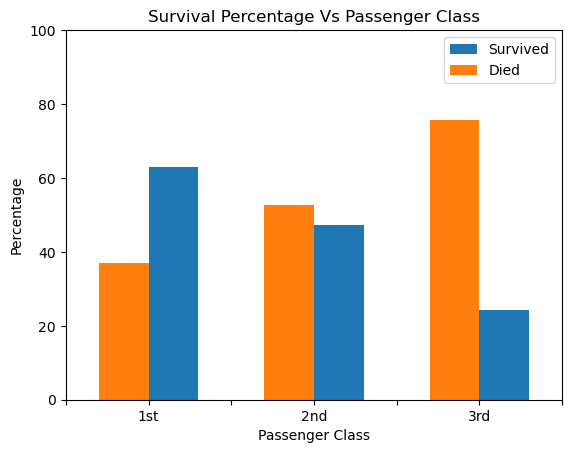

In [242]:
class_dict_ACC, class_dict_TOT, class_dict_SUR, class_dict_DEA = {}, {}, {}, {}
for i in range(len(train_df["Pclass"])):
    if train_df["Pclass"][i] in class_dict_SUR:
        class_dict_TOT[train_df["Pclass"][i]] += 1
        if train_df["Survived"][i] == 1:
            class_dict_SUR[train_df["Pclass"][i]] = class_dict_SUR[train_df["Pclass"][i]] + 1
    else:
        class_dict_SUR[train_df["Pclass"][i]] = 0
        class_dict_TOT[train_df["Pclass"][i]] = 1
        if train_df["Survived"][i] == 1:
            class_dict_SUR[train_df["Pclass"][i]] = class_dict_SUR[train_df["Pclass"][i]] + 1
for i in class_dict_SUR:
    val = class_dict_SUR[i]/class_dict_TOT[i] * 100
    class_dict_DEA[i] = 100-val
    class_dict_ACC[i] = val
print(class_dict_ACC, class_dict_DEA)
plt.bar(np.linspace(0,2,3)+0.15, sorted(list(class_dict_ACC.values()), reverse=True), width = 0.3, label="Survived")
plt.bar(np.linspace(0,2,3)-0.15, sorted(list(class_dict_DEA.values())), width = 0.3, label = "Died")
plt.xticks([-0.5,0.0,0.5,1.0,1.5,2.0,2.5],["","1st","","2nd","","3rd",""])
plt.xlabel("Passenger Class")
plt.ylabel("Percentage")
plt.title("Survival Percentage Vs Passenger Class")
plt.ylim(0,100)
plt.legend()
plt.show()

There is a clear trend with the ticket class of the passenger and the chance of survival with the higher the class the more likely the chance of survival.

### Sex:

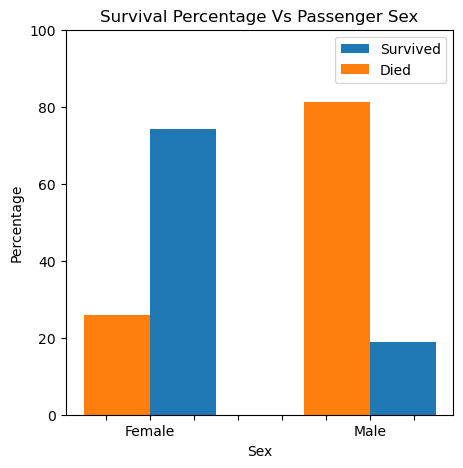

In [243]:
sex_result = train_df.groupby('Sex')['Survived'].agg(['mean','count']).reset_index()
sex_result['Survival Percentage'] = sex_result['mean'] * 100
sex_result['Death Percentage'] = 100 - sex_result['Survival Percentage']
plt.figure(figsize = (5, 5))
plt.bar(np.linspace(0,1,2)+0.15, sex_result['Survival Percentage'], width = 0.3, label = "Survived")
plt.bar(np.linspace(0,1,2)-0.15, sex_result['Death Percentage'], width = 0.3,label = 'Died')
plt.xlabel("Sex")
plt.ylabel("Percentage")
plt.title("Survival Percentage Vs Passenger Sex")
plt.xticks([-0.2,0.0,0.2,0.4,0.6,0.8,1,1.2],["","Female","","","","","Male",""])
plt.legend()
plt.ylim(0,100)
plt.show()

As expected a far grater proportion of women survived than men.

### Age:

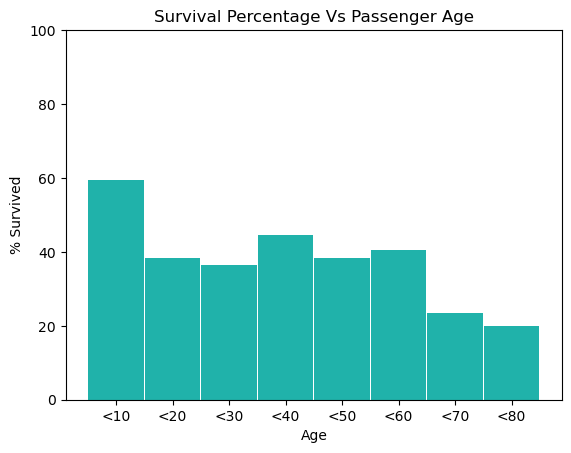

In [244]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
age_df = pd.DataFrame({"Survived":train_df["Survived"]})
age_df['Age Group'] = pd.cut(train_df['Age'], bins)
age_result = age_df.groupby('Age Group')['Survived'].agg(['mean','count']).reset_index()
age_result['Survival Percentage'] = age_result['mean'] * 100
plt.bar(range(8), age_result['Survival Percentage'], color = 'lightseagreen', width = 0.98)
plt.xlabel("Age")
plt.xticks(range(8),["<10","<20","<30","<40","<50","<60","<70","<80"])
plt.ylabel("% Survived")
plt.title("Survival Percentage Vs Passenger Age")
plt.ylim(0,100)
plt.show()

As expected, young children had the bes chance of survival, between 10-60 the chances of survival remain similar and for ages greater than 60 there is a sharp drop in survival.

### SibSp:

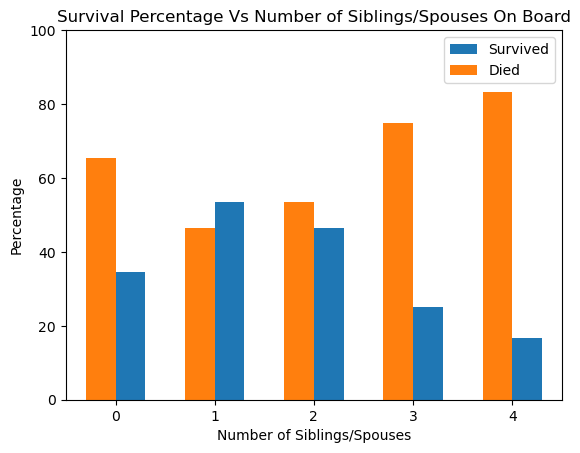

In [245]:
sib_result = train_df.groupby('SibSp')['Survived'].agg(['mean','count']).reset_index()
sib_result['Survival Percentage'] = sib_result['mean'] * 100
sib_result['Death Percentage'] = 100 - sib_result['Survival Percentage']
plt.bar(sib_result['SibSp']+0.15, sib_result['Survival Percentage'], width = 0.3,label='Survived')
plt.bar(sib_result['SibSp']-0.15, sib_result['Death Percentage'], width = 0.3,label='Died')
plt.xlabel("Number of Siblings/Spouses")
plt.ylabel("Percentage")
plt.title("Survival Percentage Vs Number of Siblings/Spouses On Board")
plt.xlim(-0.5,4.5)
plt.ylim(0,100)
plt.legend()
plt.show()


Those with more than 4 siblings/spouses on board all had survival percentage of 0% so were left of the graph. But there is a clear trend that there is an advantage to have a sibling/spouse on board, but if one has to many the chances of survival reduce likely due to limited space on life rafts.

### Parch:

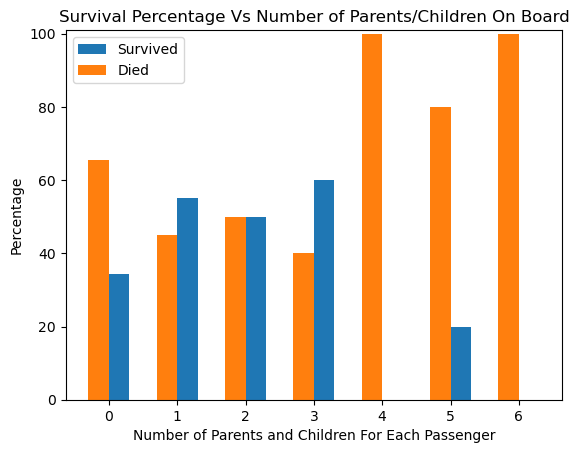

In [246]:
parch_result = train_df.groupby('Parch')['Survived'].agg(['mean','count']).reset_index()
parch_result['Survival Percentage'] = parch_result['mean'] * 100
parch_result['Death Percentage'] = 100 - parch_result['Survival Percentage']
plt.bar(parch_result['Parch']+0.15, parch_result['Survival Percentage'], width = 0.3,label= "Survived")
plt.bar(parch_result['Parch']-0.15, parch_result['Death Percentage'], width = 0.3,label="Died")
plt.xlabel("Number of Parents and Children For Each Passenger")
plt.ylabel("Percentage")
plt.title("Survival Percentage Vs Number of Parents/Children On Board")
plt.ylim(0,101)
plt.legend()
plt.show()

This graph shows similar trends to the SibSp data which is expected as the 2 are portraying related data.

### Fare:

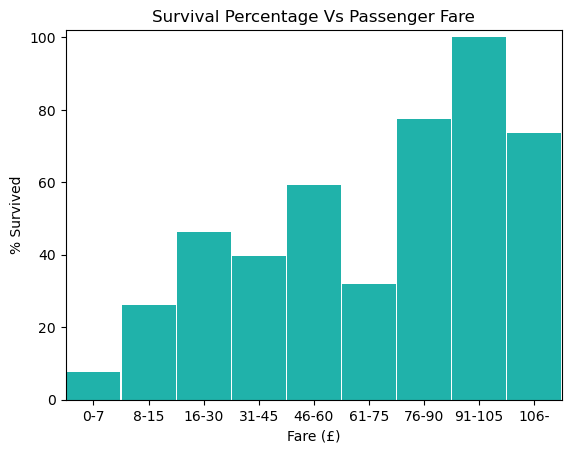

In [247]:
bins = [0, 7,15, 30, 45 ,60, 75, 90, 105, 550]
fare_df = pd.DataFrame({"Survived":train_df["Survived"]})
fare_df['Fare Group'] = pd.cut(train_df['Fare'], bins)
fare_result = fare_df.groupby('Fare Group')['Survived'].agg(['mean','count']).reset_index()
fare_result['Survival Percentage'] = fare_result['mean'] * 100
plt.bar(range(len(bins)-1), fare_result['Survival Percentage'], color = 'lightseagreen', width = 0.98)
plt.xlabel("Fare (£)")
plt.xticks(range(9),["0-7","8-15","16-30","31-45","46-60","61-75","76-90","91-105","106-",])
plt.ylabel("% Survived")
plt.title("Survival Percentage Vs Passenger Fare")
plt.ylim(0,102)
plt.xlim(-0.5,8.5)
plt.show()

Generally the more paid for the ticket the higher the chance of survival. This matches the correlation from passenger class.

### Cabin:

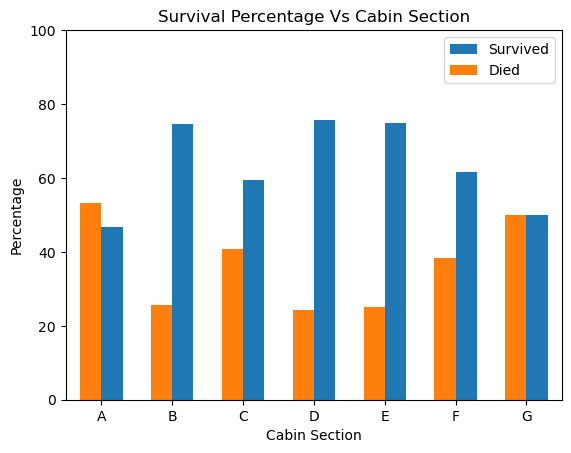

In [256]:
cab_result = train_df.groupby('Cabin')['Survived'].agg(['mean','count']).reset_index()
cab_result['Survival Percentage'] = cab_result['mean'] * 100
cab_result['Death Percentage'] = 100 - cab_result['Survival Percentage']
plt.xlabel("Cabin Section")
plt.ylabel("Percentage")
plt.title("Survival Percentage Vs Cabin Section")
plt.bar(np.linspace(0,7,8)+0.15, cab_result['Survival Percentage'], width = 0.3, label="Survived")
plt.bar(np.linspace(0,7,8)-0.15, cab_result['Death Percentage'], width = 0.3, label="Died")
plt.ylim(0,100)
plt.xticks(np.linspace(0,7,8),["A","B","C","D","E","F","G",""])
plt.xlim(-0.5,6.5)
plt.legend()
plt.show()

From the graph above it is clear that several of the cabin locations had a large difference between the percentage that survived and died from that cabin.

### Embarked:

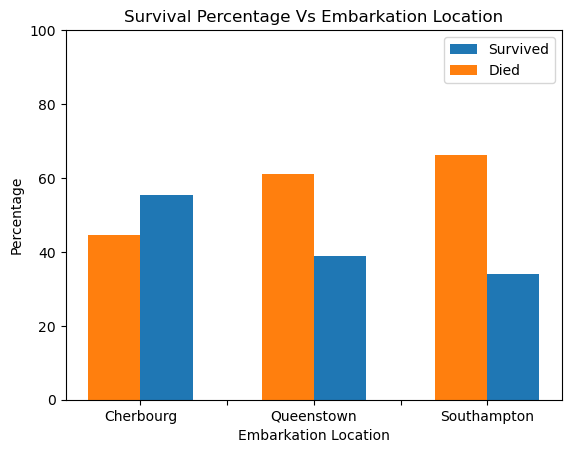

In [248]:
emb_result = train_df.groupby('Embarked')['Survived'].agg(['mean','count']).reset_index()
emb_result['Survival Percentage'] = emb_result['mean'] * 100
emb_result['Death Percentage'] = 100 - emb_result['Survival Percentage']
plt.xlabel("Embarkation Location")
plt.ylabel("Percentage")
plt.title("Survival Percentage Vs Embarkation Location")
plt.bar(np.linspace(0,2,3)+0.15, emb_result['Survival Percentage'], width = 0.3, label="Survived")
plt.bar(np.linspace(0,2,3)-0.15, emb_result['Death Percentage'], width = 0.3, label="Died")
plt.xticks([0,0.5,1,1.5,2],["Cherbourg","","Queenstown","","Southampton"])
plt.ylim(0,100)
plt.legend()
plt.show()


Those departing from Queenstown and Southampton least likely to survive. Interestingly, the chance of survival decreases the later you boarded the ship (the ship was first boarded at Cherbourg, then Queenstown then Southampton).

## Creating Models:

### Random Forrest Approach:

To optimize a random forrest model for this data a cross validation of all possible models will be ran. The criteria for the cross validation will be determined by maximizing and accuracy of the trees. During the feature selection the sklearn random forrest classifier will have these parameters:

- Number of trees: 100 (default)
- Criterion: gini (default)
- Max tree depth: 5
- Min samples to split: 2 (default)
- Min samples to leaf: 1 (default)

These parameters will be optimized once the features are selected.

### Cross Validation of Features

In [279]:
train_data, test_data = train_test_split(preprocessed_train_df,test_size=0.1)
combinations = []
inputs = input_features
for i in range(len(inputs) + 1):
    for subsets in itertools.combinations(inputs, i):
        if subsets != ():
            combinations.append(subsets)          
for i in range(len(combinations)):
    combinations[i] = list(combinations[i])

In [281]:
winner = []
all_accuracies = []
for _ in range(100):
    accuracies = []
    train_data_X, test_data_X, train_data_Y ,test_data_Y = train_test_split(preprocessed_train_df.drop('Survived',axis=1),preprocessed_train_df['Survived'],test_size=0.15)
    for i in range(len(combinations)):
        input_df = train_data_X[combinations[i]]
        test_df = test_data_X[combinations[i]]
        myforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
        myforest.fit(input_df,train_data_Y)        
        prediction_01 = myforest.predict(test_df)   
        accuracy = accuracy_score(test_data_Y,prediction_01)
        accuracies.append(accuracy)
    winner.append(np.argmax(accuracies))
    all_accuracies.append(accuracies)
    print(_)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [317]:
tp_acc = np.transpose(all_accuracies)
acc_ranges = [[round(min(i),3),round(max(i),3)] for i in tp_acc]
mean_acc = [np.mean(i) for i in tp_acc]
cross_val_df = pd.DataFrame({"Model":combinations,"Accuracy":mean_acc,"Range":acc_ranges})
sorted_df = cross_val_df.sort_values(by="Accuracy", ascending=False)
top_30_df = sorted_df.head(30)
print("Data Frame of 30/2047 Most Consistently Accurate Models:")
top_30_df.head(15)

Data Frame of 30/2047 Most Consistently Accurate Models:


,Model,Accuracy,Range
1822,"[Pclass, Name, Sex, Age, SibSp, Parch, Embarke...",0.826791,"[0.761, 0.888]"
1986,"[Pclass, Name, Sex, Age, SibSp, Parch, Cabin, ...",0.826269,"[0.754, 0.903]"
2039,"[Pclass, Name, Sex, Age, SibSp, Parch, Cabin, ...",0.824776,"[0.746, 0.903]"
2035,"[Pclass, Name, Sex, Age, SibSp, Parch, Fare, C...",0.824403,"[0.739, 0.903]"
1618,"[Pclass, Sex, Age, SibSp, Parch, Embarked, Tic...",0.823955,"[0.746, 0.896]"
1995,"[Pclass, Name, Sex, Age, Parch, Fare, Cabin, E...",0.823134,"[0.731, 0.881]"
1990,"[Pclass, Name, Sex, Age, SibSp, Fare, Cabin, E...",0.823060,"[0.746, 0.896]"
1038,"[Pclass, Name, Sex, Age, Cabin, Embarked]",0.822910,"[0.754, 0.896]"
2000,"[Pclass, Name, Sex, Age, Fare, Cabin, Embarked...",0.822687,"[0.746, 0.896]"
1161,"[Pclass, Sex, Age, SibSp, Embarked, Ticket_num...",0.822612,"[0.761, 0.896]"


In [309]:
features = []
for i in top_30_df["Model"]:
    features.append(i)
flattened_features = [i for j in features for i in j]
print(f'Average number of features in top 30/2047 models: {round(sum(len(i) for i in features)/30)}')
print('Feature Appearances in Top 30/2047 Models:')
Counter(flattened_features)

Average number of features in top 30/2047 models: 8
Feature Appearances in Top 30/2047 Models:


Counter({'Pclass': 30,
         'Name': 22,
         'Sex': 30,
         'Age': 30,
         'SibSp': 22,
         'Parch': 16,
         'Embarked': 30,
         'Ticket_number': 27,
         'Cabin': 17,
         'Ticket_item': 12,
         'Fare': 12})

Above it is clear to see that the most important features Pclass, Sex, Age, and Embarked With all appearing in all 30 models, this fits the trends seen in the data exploration section. The average number of features in the 30 models is 8. Therefore to chose the final model the top 8 highest appearing features in the top 30 models will be chosen:

- Pclass
- Sex
- Age
- Embarked
- Ticket_number
- Name
- SibSp
- Parch

Interestingly, this is the same as the top model.

## Optimizing Random Forrest Parameters:

Firstly The number of Trees in the forrest will be varied.

In [330]:
final_features = ['Pclass','Sex','Age','Embarked','Ticket_number','Name','SibSp','Parch']
nTrees_accuracies = []
for _ in range(100):
    accuracies = []
    train_data_X, test_data_X, train_data_Y ,test_data_Y = train_test_split(preprocessed_train_df.drop('Survived',axis=1),preprocessed_train_df['Survived'],test_size=0.15)
    for i in range(25,400,5):
        input_df = train_data_X[final_features]
        test_df = test_data_X[final_features]
        myforest = RandomForestClassifier(n_estimators=i, max_depth=5, random_state=1)
        myforest.fit(input_df,train_data_Y)        
        prediction_01 = myforest.predict(test_df)   
        accuracy = accuracy_score(test_data_Y,prediction_01)
        accuracies.append(accuracy)
    nTrees_accuracies.append(accuracies)

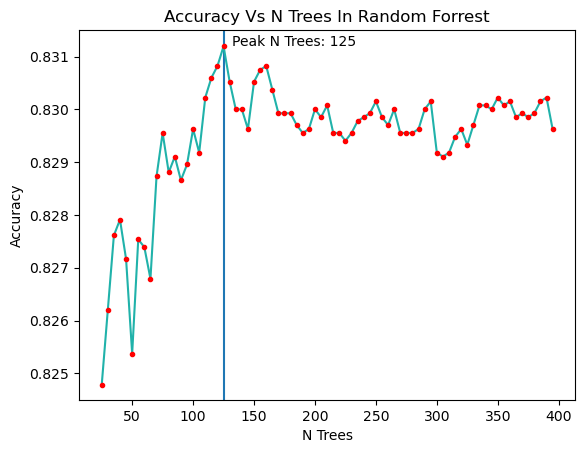

In [365]:
tp_nTrees_accuracies = np.transpose(nTrees_accuracies)
nTrees_acc_ranges = [[round(min(i),3),round(max(i),3)] for i in tp_nTrees_accuracies]
nTrees_mean_acc = [np.mean(i) for i in tp_nTrees_accuracies]
nTrees_df = pd.DataFrame({"n Trees":range(25,400,5),"Accuracy":nTrees_mean_acc,"Range":nTrees_acc_ranges})
plt.vlines(nTrees_df['n Trees'][np.argmax(nTrees_df['Accuracy'])],0.8245,0.8315)
plt.plot(nTrees_df['n Trees'], nTrees_df['Accuracy'],'lightseagreen')
plt.plot(nTrees_df['n Trees'], nTrees_df['Accuracy'],'r.')
plt.annotate(f'Peak N Trees: {nTrees_df["n Trees"][np.argmax(nTrees_df["Accuracy"])]}',xy=(120,0.831),xytext=(132,0.8312),)
plt.ylim(0.8245,0.8315),plt.title('Accuracy Vs N Trees In Random Forrest'),plt.xlabel('N Trees'),plt.ylabel('Accuracy')
plt.show()

The number of trees in the random forrest will new be set at 125 rather than the default 100.

Max depth will now be varied:

In [351]:
depth_accuracies = []
for _ in range(100):
    accuracies = []
    train_data_X, test_data_X, train_data_Y ,test_data_Y = train_test_split(preprocessed_train_df.drop('Survived',axis=1),preprocessed_train_df['Survived'],test_size=0.15)
    for i in range(1,20):
        input_df = train_data_X[final_features]
        test_df = test_data_X[final_features]
        myforest = RandomForestClassifier(n_estimators=125, max_depth=i, random_state=1)
        myforest.fit(input_df,train_data_Y)        
        prediction_01 = myforest.predict(test_df)   
        accuracy = accuracy_score(test_data_Y,prediction_01)
        accuracies.append(accuracy)
    depth_accuracies.append(accuracies)

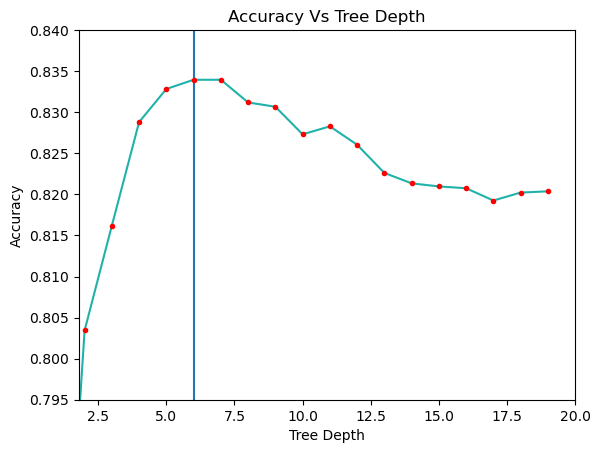

In [364]:
tp_depth_accuracies = np.transpose(depth_accuracies)
depth_acc_ranges = [[round(min(i),3),round(max(i),3)] for i in tp_depth_accuracies]
depth_mean_acc = [np.mean(i) for i in tp_depth_accuracies]
depth_df = pd.DataFrame({"n Trees":range(1,20),"Accuracy":depth_mean_acc,"Range":depth_acc_ranges})
plt.vlines(6,0.795,0.84),plt.xlim(1.8,20),plt.ylim(0.795,0.84)
plt.plot(depth_df['n Trees'], depth_df['Accuracy'],'lightseagreen')
plt.plot(depth_df['n Trees'], depth_df['Accuracy'],'r.')
plt.title('Accuracy Vs Tree Depth'),plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.show()

The optimal tree depth is ~ 6 before the data is over-fitted and accuracy reduces at greater tree depths.

Minimum samples to split an internal node now varied:

In [384]:
split_node_accuracies = []
for _ in range(200):
    accuracies = []
    train_data_X, test_data_X, train_data_Y ,test_data_Y = train_test_split(preprocessed_train_df.drop('Survived',axis=1),preprocessed_train_df['Survived'],test_size=0.15)
    for i in range(1,20):
        input_df = train_data_X[final_features]
        test_df = test_data_X[final_features]
        myforest = RandomForestClassifier(n_estimators=125, max_depth=6,min_samples_split=i ,random_state=1)
        myforest.fit(input_df,train_data_Y)        
        prediction_01 = myforest.predict(test_df)   
        accuracy = accuracy_score(test_data_Y,prediction_01)
        accuracies.append(accuracy)
    split_node_accuracies.append(accuracies)

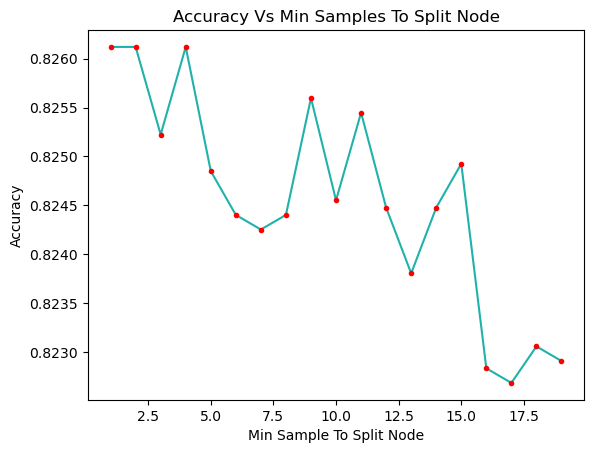

In [383]:
tp_split_accuracies = np.transpose(split_node_accuracies)
split_acc_ranges = [[round(min(i),3),round(max(i),3)] for i in tp_split_accuracies]
split_mean_acc = [np.mean(i) for i in tp_split_accuracies]
split_df = pd.DataFrame({"n Trees":range(1,20),"Accuracy":split_mean_acc,"Range":split_acc_ranges})
plt.plot(split_df['n Trees'], split_df['Accuracy'],'lightseagreen'),plt.plot(split_df['n Trees'], split_df['Accuracy'],'r.')
plt.title('Accuracy Vs Min Samples To Split Node'),plt.xlabel('Min Sample To Split Node')
plt.ylabel('Accuracy')
plt.show()

The min samples to split an internal node has the greatest accuracy at values of 1,2,4. I will use the default of 2.

Minium samples required at leaf nodes will be varied:

In [386]:
leaf_accuracies = []
for _ in range(200):
    accuracies = []
    train_data_X, test_data_X, train_data_Y ,test_data_Y = train_test_split(preprocessed_train_df.drop('Survived',axis=1),preprocessed_train_df['Survived'],test_size=0.15)
    for i in range(1,20):
        input_df = train_data_X[final_features]
        test_df = test_data_X[final_features]
        myforest = RandomForestClassifier(n_estimators=125, max_depth=6,min_samples_leaf=i ,random_state=1)
        myforest.fit(input_df,train_data_Y)        
        prediction_01 = myforest.predict(test_df)   
        accuracy = accuracy_score(test_data_Y,prediction_01)
        accuracies.append(accuracy)
    leaf_accuracies.append(accuracies)

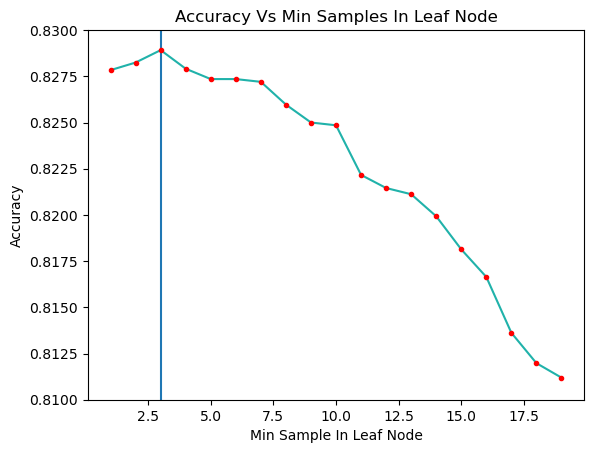

In [390]:
tp_leaf_accuracies = np.transpose(leaf_accuracies)
leaf_acc_ranges = [[round(min(i),3),round(max(i),3)] for i in tp_leaf_accuracies]
leaf_mean_acc = [np.mean(i) for i in tp_leaf_accuracies]
leaf_df = pd.DataFrame({"n Trees":range(1,20),"Accuracy":leaf_mean_acc,"Range":leaf_acc_ranges})
plt.vlines(3,0.81,0.83)
plt.plot(leaf_df['n Trees'], leaf_df['Accuracy'],'lightseagreen'),plt.plot(leaf_df['n Trees'], leaf_df['Accuracy'],'r.')
plt.title('Accuracy Vs Min Samples In Leaf Node'),plt.xlabel('Min Sample In Leaf Node')
plt.ylabel('Accuracy'),plt.ylim(0.81,0.83)
plt.show()

The random forrest has a maximum accuracy with a minimum sample at leaf of 3.

### Final Random Forrest Model:

Average accuracy of final model after 100 train test splits: 0.83045
With a range of accuracies between 0.761 -- 0.91


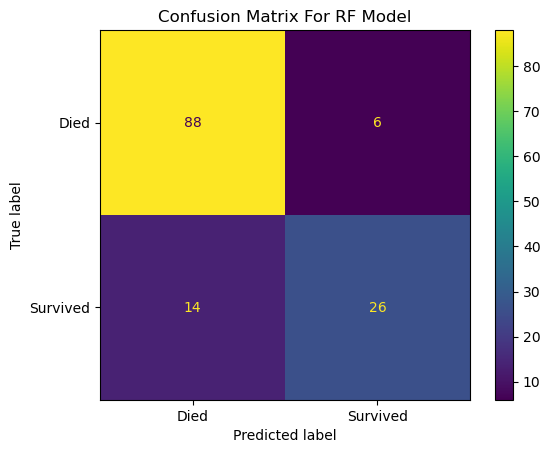

In [405]:
final_accuracies = []
for _ in range(100):
    accuracies = []
    train_data_X, test_data_X, train_data_Y ,test_data_Y = train_test_split(preprocessed_train_df.drop('Survived',axis=1),preprocessed_train_df['Survived'],test_size=0.15)
    input_df = train_data_X[final_features]
    test_df = test_data_X[final_features]
    myforest = RandomForestClassifier(n_estimators=125, max_depth=6,min_samples_leaf=3 ,random_state=1)
    myforest.fit(input_df,train_data_Y)        
    prediction_01 = myforest.predict(test_df)   
    accuracy = accuracy_score(test_data_Y,prediction_01)
    final_accuracies.append(accuracy)
    if _ == 99:
        confusion_matrix = metrics.confusion_matrix(test_data_Y, prediction_01)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Died', 'Survived'])
print(f'Average accuracy of final model after 100 train test splits: {round(np.mean(final_accuracies),5)}')
print(f'With a range of accuracies between {round(min(final_accuracies),3)} -- {round(max(final_accuracies),3)}')
cm_display.plot()
plt.title('Confusion Matrix For RF Model')
plt.show()

### Creating Submission:

In [391]:
final_input_df = preprocessed_train_df[final_features]
final_test_df = preprocessed_sub_df[final_features]
final_forest = RandomForestClassifier(n_estimators=125, max_depth=6, min_samples_leaf=3, random_state=1)
final_forest.fit(final_input_df,preprocessed_train_df['Survived'])
final_prediction = final_forest.predict(final_test_df)
predictions_df = pd.DataFrame({'PassengerId':sub_df['PassengerId'],'Survived':final_prediction})
print(predictions_df)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


In [407]:
#predictions_df.to_csv('TitanicSubmission.csv',index=False)